In [1]:
# Find possible anomalous User Agent strings
from ssh2.session import Session
import socket

class SSHCommand:
    address = ""
    username = ""
    password = ""
    
    def __init__(self, address="127.0.0.1", username="none", password="none"):
        self.address = address
        self.username = username
        self.password = password
    
    def execute(self, command = ""):
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.connect((self.address, 22))
        session = Session()
        session.handshake(sock)
        session.userauth_password(self.username, self.password)
        channel = session.open_session()
        channel.execute(command)
        result = ""
        size, result = channel.read()
        while size > 0:
            size, data = channel.read()
            result = result + data
        channel.close()
        session.disconnect()
        return result.decode('ascii')


In [2]:
ssh = SSHCommand(address='172.16.1.17', username='admin', password='password')
result = ssh.execute('echo -e \"timestamp\tuid\torig_host\torig_port\tresp_host\tresp_port\ttrans_depth\tmethod\thost\turi\tversion\tuser_agent\trequest_body_len\tresponse_body_len\tstatus_code\tstatus_msg\" && zcat /nsm/zeek/logs/2021-09-08/http* | jq -j \'select(.user_agent != null) | .ts, \"\t\", .uid, \"\t\", .[\"id.orig_h\"], \"\t\", .[\"id.orig_p\"], \"\t\", .[\"id.resp_h\"], \"\t\", .[\"id.resp_p\"], \"\t\", .trans_depth, \"\t\", .method, \"\t\", .host, \"\t\", .uri, \"\t\", .version, \"\t\", .user_agent, \"\t\", .request_body_len, \"\t\", .response_body_len, \"\t\", .status_code, \"\t\", .status_msg, \"\n\"\'')

In [3]:
from io import StringIO
import pandas as pd

def string_to_df(data):
    return pd.read_csv(StringIO(data), sep="\t")

df = string_to_df(result)
#all_pkts = df['orig_pkts'] + df['resp_pkts']
#all_bytes = df['orig_bytes'] + df['resp_bytes']
#total_pkts = df.sum('all_pkts')
#print(total_pkts)
#df["all_pkts"] = all_pkts
#df["all_bytes"] = all_bytes
df

,timestamp,uid,orig_host,orig_port,resp_host,resp_port,trans_depth,method,host,uri,version,user_agent,request_body_len,response_body_len,status_code,status_msg


In [4]:
#df.drop([57145], inplace=True)
df.drop(columns=['timestamp','uid','orig_host','orig_port','resp_host','resp_port','trans_depth'], inplace=True)
df

,method,host,uri,version,user_agent,request_body_len,response_body_len,status_code,status_msg


In [5]:
def userAgent_length(user_agent):
    return len(user_agent)

def userAgent_parts(user_agent):
    return len(user_agent.split(' '))

def host_octal(host):
    octal = 0
    for c in host:
        octal = octal + int(ord(c))
    return octal

#def query_suffix_length(query):
#    return len(query.split('.')[-1])

#def query_domain_length(query):
#    try:
#        length =  len(query.split('.')[-2])
#    except:
#        length = 0
#    return length

ualengths = [userAgent_length(user_agent) for user_agent in df['user_agent']]
uaparts = [userAgent_parts(user_agent) for user_agent in df['user_agent']]
hoctal = [host_octal(host) for host in df['host']]

#qsufflengths = [query_suffix_length(query) for query in df['query']]
#qdomlengths = [query_domain_length(query) for query in df['query']]

df['ualength'] = ualengths
df['uaparts'] = uaparts
df['hoctal'] = hoctal

#df['suffixlength'] = qsufflengths
#df['domainlength'] = qdomlengths
df

,method,host,uri,version,user_agent,request_body_len,response_body_len,status_code,status_msg,ualength,uaparts,hoctal


In [6]:
data = df[['ualength', 'uaparts', 'response_body_len', 'request_body_len', 'hoctal']].to_numpy()
data

array([], shape=(0, 5), dtype=object)

In [37]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

pca = PCA(5)
pca.fit(data)
reduced = pca.transform(data)

dbscan = DBSCAN(eps=5, min_samples=5)
dbscan.fit(reduced)
y_labels = dbscan.labels_
y_labels

array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0, -1,
       -1, -1, -1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,
       -1, -1, -1, -1,  1,  1], dtype=int64)

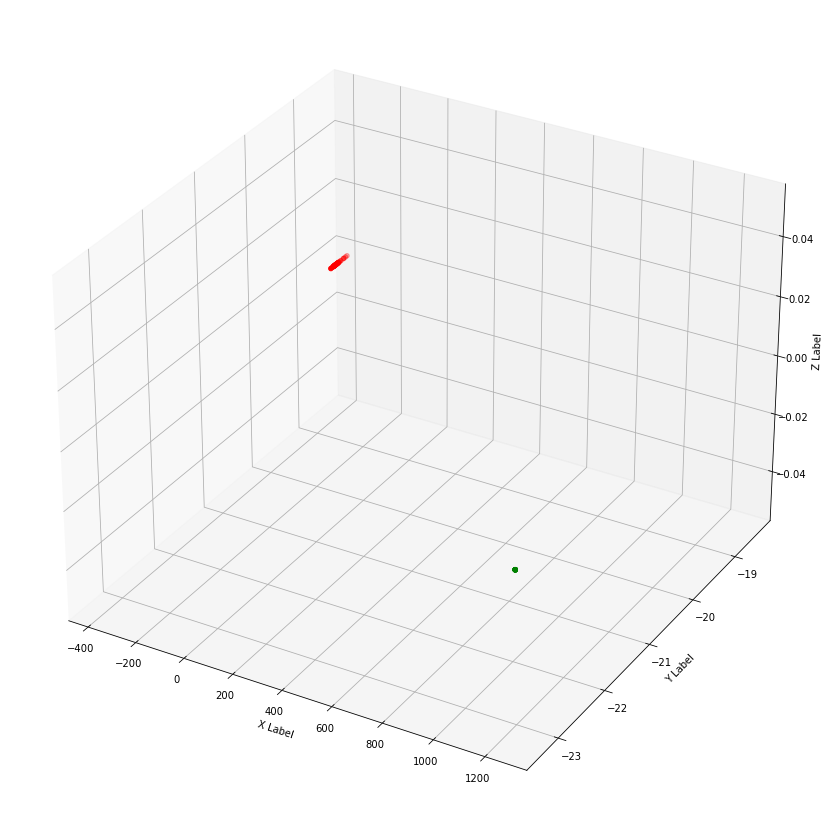

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def scatter3d(data, y_kmeans):
    clusters = len(np.unique(y_kmeans))
    colors=list("rgbcmyk")
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    ax = fig.add_subplot(111, projection='3d')
    for cluster in range(clusters):
        ax.scatter(data[y_kmeans==cluster, 0], data[y_kmeans==cluster, 1], c=colors[cluster%len(colors)])
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

scatter3d(reduced, y_labels)

In [40]:
df['cluster'] = y_labels
df.loc[df['cluster']==0]

,method,host,uri,version,user_agent,request_body_len,response_body_len,status_code,status_msg,ualength,uaparts,cluster,hoctal
1,GET,172.16.1.15,/,1.1,DummyValue,0,164,307.0,Temporary Redirect,10,1,0,546
2,GET,172.16.1.15,/,1.1,DriveCleaner Updater,0,164,307.0,Temporary Redirect,20,2,0,546
3,GET,172.16.1.15,/,1.1,EShopee,0,164,307.0,Temporary Redirect,7,1,0,546
4,GET,172.16.1.15,/,1.1,test_hInternet,0,164,307.0,Temporary Redirect,14,1,0,546
5,GET,172.16.1.15,/,1.1,ROGUE,0,164,307.0,Temporary Redirect,5,1,0,546
6,GET,172.16.1.15,/,1.1,Gator/,0,164,307.0,Temporary Redirect,6,1,0,546
7,GET,172.16.1.15,/,1.1,mez,0,164,307.0,Temporary Redirect,3,1,0,546
8,GET,172.16.1.15,/,1.1,pcsafe,0,164,307.0,Temporary Redirect,6,1,0,546
9,GET,172.16.1.15,/,1.1,ClickAdsByIE,0,164,307.0,Temporary Redirect,12,1,0,546
10,GET,172.16.1.15,/,1.1,MediaLabsSiteInstaller,0,164,307.0,Temporary Redirect,22,1,0,546


In [41]:
df.loc[df['cluster']==1]

,method,host,uri,version,user_agent,request_body_len,response_body_len,status_code,status_msg,ualength,uaparts,cluster,hoctal
20,GET,partnerweb.vmware.com,/service/vsan/all.json?lastupdatedtime,1.1,Python-urllib/3.5,0,73,200.0,OK,17,1,1,2151
45,GET,partnerweb.vmware.com,/service/vsan/all.json?lastupdatedtime,1.1,Python-urllib/3.5,0,73,200.0,OK,17,1,1,2151
46,GET,partnerweb.vmware.com,/service/vsan/all.json?lastupdatedtime,1.1,Python-urllib/3.5,0,73,200.0,OK,17,1,1,2151
47,GET,partnerweb.vmware.com,/service/vsan/all.json?lastupdatedtime,1.1,Python-urllib/3.5,0,73,200.0,OK,17,1,1,2151
48,GET,partnerweb.vmware.com,/service/vsan/all.json?lastupdatedtime,1.1,Python-urllib/3.5,0,73,200.0,OK,17,1,1,2151
49,GET,partnerweb.vmware.com,/service/vsan/all.json?lastupdatedtime,1.1,Python-urllib/3.5,0,73,200.0,OK,17,1,1,2151
50,GET,partnerweb.vmware.com,/service/vsan/all.json?lastupdatedtime,1.1,Python-urllib/3.5,0,73,200.0,OK,17,1,1,2151
55,GET,partnerweb.vmware.com,/service/vsan/all.json?lastupdatedtime,1.1,Python-urllib/3.5,0,73,200.0,OK,17,1,1,2151
56,GET,partnerweb.vmware.com,/service/vsan/all.json?lastupdatedtime,1.1,Python-urllib/3.5,0,73,200.0,OK,17,1,1,2151


In [11]:
df.loc[df['cluster']==2]

,method,host,uri,version,user_agent,request_body_len,response_body_len,status_code,status_msg,ualength,uaparts,cluster


In [ ]:
df.loc[df['cluster']==3]

In [ ]:
df.loc[df['cluster']==4]